# ЗАВДАННЯ 5: РЕАЛІЗАЦІЯ БАГАТОШАРОВОГО ПЕРЦЕПТРОНУ З НУЛЯ В PYTORCH

**Мета:** Глибоке розуміння фундаментальних принципів роботи нейронних мереж через реалізацію всіх компонентів з нуля.

**Dataset:** Wine Quality Dataset - передбачення якості вина за фізико-хімічними властивостями (багатокласова класифікація)

## 1. Імпорт бібліотек

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Налаштування для відтворюваності
np.random.seed(42)
torch.manual_seed(42)

# Налаштування візуалізації
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Бібліотеки завантажено")
print(f"PyTorch версія: {torch.__version__}")

## 2. Підготовка даних

**Пояснення:** Правильна підготовка даних - ключ до успішного навчання нейронної мережі. Ми:
- Нормалізуємо ознаки для однакового масштабу
- Розділяємо на train/validation/test для контролю перенавчання
- Конвертуємо в тензори PyTorch

In [ ]:
def load_and_preprocess_data():
    """
    Завантаження та підготовка даних Wine Quality Dataset
    
    Returns:
        Tuple з 6 елементів: X_train, X_val, X_test, y_train, y_val, y_test
    """
    # 1. Завантажити CSV з даними про вино
    print("Завантаження даних...")
    df = pd.read_csv('WineQT.csv')
    
    # Видалити колонку Id якщо вона є
    if 'Id' in df.columns:
        df = df.drop('Id', axis=1)
    
    print(f"Розмір датасету: {df.shape}")
    print(f"\nПерші 5 рядків:")
    print(df.head())
    
    # 2. Відокремити ознаки (X) та мітки (y)
    X = df.drop('quality', axis=1).values
    y = df['quality'].values
    
    # Перетворити мітки класів на послідовні індекси (0, 1, 2, ...)
    unique_classes = np.unique(y)
    print(f"\nУнікальні класи якості: {unique_classes}")
    
    class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
    y = np.array([class_mapping[cls] for cls in y])
    num_classes = len(unique_classes)
    
    print(f"Кількість класів: {num_classes}")
    print(f"Розподіл класів: {np.bincount(y)}")
    
    # 3. Розділити дані на тренувальну/валідаційну/тестову вибірки
    # Спочатку розділяємо на train+val (80%) та test (20%)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Потім розділяємо train+val на train (64%) та val (16%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
    )
    
    print(f"\nРозміри вибірок:")
    print(f"Train: {X_train.shape[0]} зразків")
    print(f"Validation: {X_val.shape[0]} зразків")
    print(f"Test: {X_test.shape[0]} зразків")
    
    # 4. Нормалізувати ознаки за допомогою StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    print("\nДані нормалізовано (StandardScaler)")
    
    # 5. Конвертувати в тензори PyTorch
    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_val = torch.LongTensor(y_val)
    y_test = torch.LongTensor(y_test)
    
    print("\n✓ Дані підготовлено та конвертовано в тензори PyTorch")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, num_classes, unique_classes

# Завантажити дані
X_train, X_val, X_test, y_train, y_val, y_test, num_classes, class_names = load_and_preprocess_data()

Завантаження даних...
Розмір датасету: (1143, 12)

Перші 5 рядків:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality

## 3. Функції активації (реалізація з нуля)

**Пояснення:** Функції активації вводять нелінійність у модель. Реалізуємо:
- **ReLU**: f(x) = max(0, x) - проста і ефективна
- **Tanh**: f(x) = tanh(x) - виходи в діапазоні [-1, 1]
- **Sigmoid**: f(x) = 1/(1+e^(-x)) - виходи в діапазоні [0, 1]

Кожна функція має похідну для backpropagation.

In [ ]:
class ActivationFunctions:
    """Клас з функціями активації та їх похідними"""
    
    @staticmethod
    def relu(x, derivative=False):
        """
        ReLU: f(x) = max(0, x)
        Похідна: 1 для x > 0, 0 для x <= 0
        """
        if derivative:
            return (x > 0).float()  # Похідна для backpropagation
        return torch.maximum(torch.zeros_like(x), x)
    
    @staticmethod
    def tanh(x, derivative=False):
        """
        Tanh: f(x) = (e^x - e^(-x)) / (e^x + e^(-x))
        Похідна: 1 - tanh²(x)
        """
        if derivative:
            return 1 - torch.tanh(x)**2  # Похідна через тотожність
        return torch.tanh(x)
    
    @staticmethod
    def sigmoid(x, derivative=False):
        """
        Sigmoid: f(x) = 1 / (1 + e^(-x))
        Похідна: sigmoid(x) * (1 - sigmoid(x))
        """
        sig = 1 / (1 + torch.exp(-x))
        if derivative:
            return sig * (1 - sig)
        return sig
    
    @staticmethod
    def softmax(x):
        """
        Softmax для вихідного шару (багатокласова класифікація)
        Використовуємо численно стабільний варіант
        """
        exp_x = torch.exp(x - torch.max(x, dim=0, keepdim=True)[0])
        return exp_x / torch.sum(exp_x, dim=0, keepdim=True)

# Тестування функцій активації
print("Тестування функцій активації:")
test_input = torch.tensor([[-2.0, -1.0, 0.0, 1.0, 2.0]])
print(f"Вхід: {test_input}")
print(f"ReLU: {ActivationFunctions.relu(test_input.T).T}")
print(f"Tanh: {ActivationFunctions.tanh(test_input.T).T}")
print(f"Sigmoid: {ActivationFunctions.sigmoid(test_input.T).T}")
print(f"Softmax: {ActivationFunctions.softmax(test_input.T).T}")

Тестування функцій активації:
Вхід: tensor([[-2., -1.,  0.,  1.,  2.]])
ReLU: tensor([[0., 0., 0., 1., 2.]])
Tanh: tensor([[-0.9640, -0.7616,  0.0000,  0.7616,  0.9640]])
Sigmoid: tensor([[0.1192, 0.2689, 0.5000, 0.7311, 0.8808]])
Softmax: tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364]])


## 4. Функція втрат (реалізація з нуля)

**Пояснення:** Categorical Cross-Entropy вимірює різницю між прогнозами та справжніми мітками.

Ключова оптимізація: похідна комбінації Softmax + Cross-Entropy спрощується до:
$$\frac{\partial L}{\partial z_i} = \hat{y}_i - y_i$$

In [ ]:
class LossFunctions:
    """Клас з функціями втрат"""
    
    @staticmethod
    def categorical_cross_entropy(y_pred, y_true, derivative=False):
        """
        Categorical Cross-Entropy Loss
        
        Args:
            y_pred: Прогнози після softmax (num_classes, batch_size)
            y_true: Справжні мітки класів (batch_size,)
            derivative: Якщо True, повертає градієнт
        
        Returns:
            Loss або градієнт
        """
        batch_size = y_true.shape[0]
        
        if derivative:
            # Оптимізована похідна для softmax + cross_entropy
            # Градієнт = (y_pred - y_true) для one-hot представлення
            grad = y_pred.clone()
            # Правильна індексація: grad[class_index, sample_index]
            for i in range(batch_size):
                grad[y_true[i], i] -= 1
            return grad / batch_size
        else:
            # Forward pass: обчислюємо втрати
            # L = -1/m * sum(log(y_pred[correct_class]))
            correct_logprobs = []
            for i in range(batch_size):
                correct_logprobs.append(-torch.log(y_pred[y_true[i], i] + 1e-8))
            loss = torch.sum(torch.stack(correct_logprobs)) / batch_size
            return loss

print("✓ Функції втрат реалізовано")

✓ Функції втрат реалізовано


## 5. Власна реалізація багатошарового перцептрону (MLP)

**Пояснення:** Це ядро завдання - повноцінна нейронна мережа без використання autograd.

Ключові компоненти:
1. **Ініціалізація ваг** - метод Xavier для стабільного навчання
2. **Forward pass** - обчислення виходів з кешуванням проміжних значень
3. **Backward pass** - обчислення градієнтів через ланцюгове правило
4. **Оновлення ваг** - градієнтний спуск

In [ ]:
class CustomMLP:
    """
    Багатошаровий перцептрон з нуля
    Реалізація без використання autograd
    """
    
    def __init__(self, layer_sizes, activations, learning_rate=0.01):
        """
        Ініціалізація мережі
        
        Args:
            layer_sizes: Список розмірів шарів [input_size, hidden1, hidden2, ..., output_size]
            activations: Список функцій активації для кожного шару (крім вхідного)
            learning_rate: Швидкість навчання
        """
        self.layer_sizes = layer_sizes
        self.activations = activations
        self.learning_rate = learning_rate
        self.num_layers = len(layer_sizes)
        self.parameters = {}
        
        # Ініціалізація ваг за методом Xavier (Glorot)
        # Xavier: W ~ N(0, sqrt(2/(n_in + n_out)))
        print("Ініціалізація параметрів мережі...")
        for i in range(1, self.num_layers):
            # Ваги
            limit = np.sqrt(6 / (layer_sizes[i-1] + layer_sizes[i]))
            self.parameters[f'W{i}'] = torch.FloatTensor(
                layer_sizes[i], layer_sizes[i-1]
            ).uniform_(-limit, limit)
            
            # Зміщення (bias)
            self.parameters[f'b{i}'] = torch.zeros(layer_sizes[i], 1)
            
            print(f"Шар {i}: W{i} shape = {self.parameters[f'W{i}'].shape}, "
                  f"b{i} shape = {self.parameters[f'b{i}'].shape}")
        
        print(f"\n✓ Мережа ініціалізована: {layer_sizes}")
        print(f"  Активації: {activations}")
        print(f"  Learning rate: {learning_rate}")
    
    def forward(self, X, training=True):
        """
        Прямий прохід через мережу
        
        Args:
            X: Вхідні дані (batch_size, input_size)
            training: Якщо True, кешує проміжні значення для backprop
        
        Returns:
            predictions: Вихід мережі після softmax
            cache: Словник з проміжними значеннями (якщо training=True)
        """
        cache = {}
        A = X.T  # Транспонуємо для зручності: (input_size, batch_size)
        cache['A0'] = A
        
        # Прохід через приховані шари
        for i in range(1, self.num_layers):
            # Лінійна комбінація: Z = W·A_prev + b
            Z = self.parameters[f'W{i}'] @ A + self.parameters[f'b{i}']
            
            # Активація
            if i == self.num_layers - 1:
                # Вихідний шар: використовуємо softmax
                A = ActivationFunctions.softmax(Z)
            else:
                # Прихований шар: використовуємо задану активацію
                activation_func = getattr(ActivationFunctions, self.activations[i-1])
                A = activation_func(Z)
            
            # Кешуємо для backpropagation
            if training:
                cache[f'Z{i}'] = Z
                cache[f'A{i}'] = A
        
        if training:
            return A, cache
        else:
            return A
    
    def backward(self, X, y, cache):
        """
        Зворотній прохід (backpropagation)
        
        Args:
            X: Вхідні дані (batch_size, input_size)
            y: Справжні мітки (batch_size,)
            cache: Проміжні значення з forward pass
        """
        batch_size = X.shape[0]
        gradients = {}
        
        # Градієнт для вихідного шару (Softmax + Cross-Entropy)
        # dL/dZ = y_pred - y_true (оптимізована формула)
        dZ = LossFunctions.categorical_cross_entropy(
            cache[f'A{self.num_layers-1}'], y, derivative=True
        )
        
        # Зворотнє поширення через шари
        for i in range(self.num_layers - 1, 0, -1):
            # Градієнти для ваг та зміщень
            A_prev = cache[f'A{i-1}']
            
            # dL/dW = (1/m) * dZ @ A_prev^T
            gradients[f'dW{i}'] = dZ @ A_prev.T
            
            # dL/db = (1/m) * sum(dZ, axis=1)
            gradients[f'db{i}'] = torch.sum(dZ, dim=1, keepdim=True)
            
            # Поширення градієнта на попередній шар
            if i > 1:
                # dL/dA_prev = W^T @ dZ
                dA = self.parameters[f'W{i}'].T @ dZ
                
                # dL/dZ_prev = dA * activation'(Z_prev)
                activation_func = getattr(ActivationFunctions, self.activations[i-2])
                dZ = dA * activation_func(cache[f'Z{i-1}'], derivative=True)
        
        # Оновлення параметрів (градієнтний спуск)
        for i in range(1, self.num_layers):
            self.parameters[f'W{i}'] -= self.learning_rate * gradients[f'dW{i}']
            self.parameters[f'b{i}'] -= self.learning_rate * gradients[f'db{i}']
    
    def train_step(self, X, y):
        """
        Один крок навчання
        
        Returns:
            loss: Значення функції втрат
            accuracy: Точність на даному batch
        """
        # Forward pass
        predictions, cache = self.forward(X, training=True)
        
        # Обчислення втрат
        loss = LossFunctions.categorical_cross_entropy(predictions, y)
        
        # Backward pass
        self.backward(X, y, cache)
        
        # Обчислення точності
        pred_classes = torch.argmax(predictions, dim=0)
        accuracy = (pred_classes == y).float().mean()
        
        return loss.item(), accuracy.item()
    
    def predict(self, X):
        """
        Прогнозування класів
        
        Returns:
            Predicted class labels
        """
        predictions = self.forward(X, training=False)
        return torch.argmax(predictions, dim=0)
    
    def evaluate(self, X, y):
        """
        Оцінка моделі
        
        Returns:
            loss, accuracy
        """
        predictions = self.forward(X, training=False)
        loss = LossFunctions.categorical_cross_entropy(predictions, y)
        pred_classes = torch.argmax(predictions, dim=0)
        accuracy = (pred_classes == y).float().mean()
        return loss.item(), accuracy.item()

print("✓ Клас CustomMLP реалізовано")

✓ Клас CustomMLP реалізовано


## 6. Функція навчання власної моделі

In [ ]:
def train_custom_model(model, X_train, y_train, X_val, y_val, epochs=1000, print_every=100):
    """
    Навчання власної моделі
    
    Returns:
        history: Словник з метриками навчання
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    print(f"\n{'='*60}")
    print("НАВЧАННЯ ВЛАСНОЇ МОДЕЛІ (Custom MLP)")
    print(f"{'='*60}\n")
    
    for epoch in range(epochs):
        # Навчання
        train_loss, train_acc = model.train_step(X_train, y_train)
        
        # Валідація
        val_loss, val_acc = model.evaluate(X_val, y_val)
        
        # Збереження метрик
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Виведення прогресу
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:4d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    print(f"\n{'='*60}")
    print("✓ Навчання завершено")
    print(f"{'='*60}\n")
    
    return history

print("✓ Функція навчання готова")

✓ Функція навчання готова


**Continue iteration**

## 7. PyTorch реалізація для порівняння

**Пояснення:** Ця реалізація слугує еталоном. Використовуємо вбудовані механізми PyTorch:
- Automatic differentiation (autograd)
- Оптимізатори (Adam)
- Вбудовані функції втрат

Важливо: використовуємо **однакову архітектуру** для чесного порівняння.

In [ ]:
class PyTorchMLP(nn.Module):
    """
    Багатошаровий перцептрон з використанням PyTorch
    Для порівняння з власною реалізацією
    """
    
    def __init__(self, input_size, hidden_sizes, output_size, activations):
        """
        Args:
            input_size: Розмір вхідного шару
            hidden_sizes: Список розмірів прихованих шарів
            output_size: Розмір вихідного шару (кількість класів)
            activations: Список назв активацій для прихованих шарів
        """
        super(PyTorchMLP, self).__init__()
        
        # Створюємо шари
        layers = []
        prev_size = input_size
        
        # Приховані шари
        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, hidden_size))
            
            # Додаємо активацію
            if activations[i] == 'relu':
                layers.append(nn.ReLU())
            elif activations[i] == 'tanh':
                layers.append(nn.Tanh())
            elif activations[i] == 'sigmoid':
                layers.append(nn.Sigmoid())
            
            prev_size = hidden_size
        
        # Вихідний шар (без активації, бо використовуємо CrossEntropyLoss)
        layers.append(nn.Linear(prev_size, output_size))
        
        # Об'єднуємо в Sequential
        self.network = nn.Sequential(*layers)
        
        print(f"✓ PyTorch MLP створено:")
        print(f"  Архітектура: {[input_size] + hidden_sizes + [output_size]}")
        print(f"  Активації: {activations}")
    
    def forward(self, x):
        """Прямий прохід"""
        return self.network(x)

print("✓ Клас PyTorchMLP реалізовано")

✓ Клас PyTorchMLP реалізовано


### Функція навчання PyTorch моделі

In [ ]:
def train_pytorch_model(model, X_train, y_train, X_val, y_val, epochs=1000, 
                       learning_rate=0.01, print_every=100):
    """
    Навчання PyTorch моделі
    
    Args:
        model: PyTorch модель
        X_train, y_train: Тренувальні дані
        X_val, y_val: Валідаційні дані
        epochs: Кількість епох
        learning_rate: Швидкість навчання
        print_every: Як часто виводити прогрес
    
    Returns:
        history: Словник з метриками навчання
    """
    # CrossEntropyLoss включає Softmax + Cross-Entropy
    criterion = nn.CrossEntropyLoss()
    
    # Оптимізатор Adam (адаптивний градієнтний спуск)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    print(f"\n{'='*60}")
    print("НАВЧАННЯ PYTORCH МОДЕЛІ")
    print(f"{'='*60}\n")
    
    for epoch in range(epochs):
        # Режим навчання
        model.train()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass та оптимізація
        optimizer.zero_grad()  # Обнулюємо градієнти
        loss.backward()        # Обчислюємо градієнти
        optimizer.step()       # Оновлюємо ваги
        
        # Обчислення точності на тренувальній вибірці
        _, predicted = torch.max(outputs.data, 1)
        train_acc = (predicted == y_train).float().mean().item()
        
        # Валідація
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_acc = (val_predicted == y_val).float().mean().item()
        
        # Збереження метрик
        history['train_loss'].append(loss.item())
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc)
        
        # Виведення прогресу
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:4d}/{epochs} | "
                  f"Train Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc:.4f}")
    
    print(f"\n{'='*60}")
    print("✓ Навчання завершено")
    print(f"{'='*60}\n")
    
    return history

print("✓ Функція навчання PyTorch моделі готова")

✓ Функція навчання PyTorch моделі готова


## 8. Візуалізація та аналіз

**Пояснення:** Візуалізація допомагає зрозуміти процес навчання та порівняти обидві реалізації.

In [ ]:
def plot_training_history(history_custom, history_pytorch):
    """
    Візуалізація процесу навчання обох моделей
    
    Аналізуємо:
    - Швидкість збіжності
    - Наявність overfitting (різниця між train та val)
    - Стабільність навчання
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs_custom = range(1, len(history_custom['train_loss']) + 1)
    epochs_pytorch = range(1, len(history_pytorch['train_loss']) + 1)
    
    # Loss - Custom Model
    axes[0, 0].plot(epochs_custom, history_custom['train_loss'], 
                    label='Train Loss', linewidth=2, alpha=0.8)
    axes[0, 0].plot(epochs_custom, history_custom['val_loss'], 
                    label='Val Loss', linewidth=2, alpha=0.8)
    axes[0, 0].set_title('Custom MLP - Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy - Custom Model
    axes[0, 1].plot(epochs_custom, history_custom['train_acc'], 
                    label='Train Accuracy', linewidth=2, alpha=0.8)
    axes[0, 1].plot(epochs_custom, history_custom['val_acc'], 
                    label='Val Accuracy', linewidth=2, alpha=0.8)
    axes[0, 1].set_title('Custom MLP - Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Loss - PyTorch Model
    axes[1, 0].plot(epochs_pytorch, history_pytorch['train_loss'], 
                    label='Train Loss', linewidth=2, alpha=0.8)
    axes[1, 0].plot(epochs_pytorch, history_pytorch['val_loss'], 
                    label='Val Loss', linewidth=2, alpha=0.8)
    axes[1, 0].set_title('PyTorch MLP - Loss', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Accuracy - PyTorch Model
    axes[1, 1].plot(epochs_pytorch, history_pytorch['train_acc'], 
                    label='Train Accuracy', linewidth=2, alpha=0.8)
    axes[1, 1].plot(epochs_pytorch, history_pytorch['val_acc'], 
                    label='Val Accuracy', linewidth=2, alpha=0.8)
    axes[1, 1].set_title('PyTorch MLP - Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Порівняльний графік
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Порівняння Loss
    axes[0].plot(epochs_custom, history_custom['val_loss'], 
                label='Custom MLP', linewidth=2, alpha=0.8)
    axes[0].plot(epochs_pytorch, history_pytorch['val_loss'], 
                label='PyTorch MLP', linewidth=2, alpha=0.8)
    axes[0].set_title('Порівняння Validation Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Порівняння Accuracy
    axes[1].plot(epochs_custom, history_custom['val_acc'], 
                label='Custom MLP', linewidth=2, alpha=0.8)
    axes[1].plot(epochs_pytorch, history_pytorch['val_acc'], 
                label='PyTorch MLP', linewidth=2, alpha=0.8)
    axes[1].set_title('Порівняння Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Функція візуалізації історії навчання готова")

✓ Функція візуалізації історії навчання готова


In [ ]:
def plot_confusion_matrix(y_true, y_pred_custom, y_pred_pytorch, class_names):
    """
    Матриці помилок для обох моделей
    
    Показуємо:
    - Які класи плутаються найбільше
    - Чи однакові патерни помилок в обох моделях
    - Загальну якість класифікації
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Confusion Matrix для Custom MLP
    cm_custom = confusion_matrix(y_true, y_pred_custom)
    sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Custom MLP - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # Confusion Matrix для PyTorch MLP
    cm_pytorch = confusion_matrix(y_true, y_pred_pytorch)
    sns.heatmap(cm_pytorch, annot=True, fmt='d', cmap='Greens', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_title('PyTorch MLP - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    # Детальні звіти
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT - CUSTOM MLP")
    print("="*60)
    print(classification_report(y_true, y_pred_custom, 
                               target_names=[f"Class {c}" for c in class_names]))
    
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT - PYTORCH MLP")
    print("="*60)
    print(classification_report(y_true, y_pred_pytorch, 
                               target_names=[f"Class {c}" for c in class_names]))

print("✓ Функція візуалізації матриць помилок готова")

✓ Функція візуалізації матриць помилок готова


## 9. Навчання та порівняння моделей

Тепер навчимо обидві моделі з однаковою архітектурою та порівняємо результати.

In [ ]:
# Гіперпараметри (однакові для обох моделей)
input_size = X_train.shape[1]
hidden_sizes = [64, 32]  # Два приховані шари
output_size = num_classes
activations = ['relu', 'relu']  # Активації для прихованих шарів
learning_rate = 0.01
epochs = 1000

print(f"Архітектура мережі: {[input_size] + hidden_sizes + [output_size]}")
print(f"Активації: {activations}")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {epochs}")
print(f"Кількість класів: {output_size}")

Архітектура мережі: [11, 64, 32, 6]
Активації: ['relu', 'relu']
Learning rate: 0.01
Epochs: 1000
Кількість класів: 6


### 9.1. Навчання Custom MLP (власна реалізація)

In [ ]:
# Створення та навчання Custom MLP
layer_sizes = [input_size] + hidden_sizes + [output_size]
custom_model = CustomMLP(layer_sizes, activations, learning_rate)

# Навчання
import time
start_time = time.time()
history_custom = train_custom_model(custom_model, X_train, y_train, X_val, y_val, 
                                   epochs=epochs, print_every=100)
custom_train_time = time.time() - start_time

print(f"Час навчання Custom MLP: {custom_train_time:.2f} секунд")

Ініціалізація параметрів мережі...
Шар 1: W1 shape = torch.Size([64, 11]), b1 shape = torch.Size([64, 1])
Шар 2: W2 shape = torch.Size([32, 64]), b2 shape = torch.Size([32, 1])
Шар 3: W3 shape = torch.Size([6, 32]), b3 shape = torch.Size([6, 1])

✓ Мережа ініціалізована: [11, 64, 32, 6]
  Активації: ['relu', 'relu']
  Learning rate: 0.01

НАВЧАННЯ ВЛАСНОЇ МОДЕЛІ (Custom MLP)

Epoch    1/1000 | Train Loss: 1.8413 | Train Acc: 0.1477 | Val Loss: 1.8142 | Val Acc: 0.1475
Epoch    1/1000 | Train Loss: 1.8413 | Train Acc: 0.1477 | Val Loss: 1.8142 | Val Acc: 0.1475
Epoch  100/1000 | Train Loss: 1.2889 | Train Acc: 0.5157 | Val Loss: 1.2575 | Val Acc: 0.5683
Epoch  100/1000 | Train Loss: 1.2889 | Train Acc: 0.5157 | Val Loss: 1.2575 | Val Acc: 0.5683
Epoch  200/1000 | Train Loss: 1.1406 | Train Acc: 0.5472 | Val Loss: 1.1094 | Val Acc: 0.5683
Epoch  200/1000 | Train Loss: 1.1406 | Train Acc: 0.5472 | Val Loss: 1.1094 | Val Acc: 0.5683
Epoch  300/1000 | Train Loss: 1.0737 | Train Acc: 0.5636 

### 9.2. Навчання PyTorch MLP

In [ ]:
# Створення та навчання PyTorch MLP
pytorch_model = PyTorchMLP(input_size, hidden_sizes, output_size, activations)

# Навчання
start_time = time.time()
history_pytorch = train_pytorch_model(pytorch_model, X_train, y_train, X_val, y_val,
                                     epochs=epochs, learning_rate=learning_rate, 
                                     print_every=100)
pytorch_train_time = time.time() - start_time

print(f"Час навчання PyTorch MLP: {pytorch_train_time:.2f} секунд")

✓ PyTorch MLP створено:
  Архітектура: [11, 64, 32, 6]
  Активації: ['relu', 'relu']

НАВЧАННЯ PYTORCH МОДЕЛІ


НАВЧАННЯ PYTORCH МОДЕЛІ

Epoch    1/1000 | Train Loss: 1.8568 | Train Acc: 0.0985 | Val Loss: 1.6768 | Val Acc: 0.4262
Epoch  100/1000 | Train Loss: 0.4060 | Train Acc: 0.8714 | Val Loss: 1.3167 | Val Acc: 0.5628
Epoch    1/1000 | Train Loss: 1.8568 | Train Acc: 0.0985 | Val Loss: 1.6768 | Val Acc: 0.4262
Epoch  100/1000 | Train Loss: 0.4060 | Train Acc: 0.8714 | Val Loss: 1.3167 | Val Acc: 0.5628
Epoch  200/1000 | Train Loss: 0.0702 | Train Acc: 0.9973 | Val Loss: 2.5654 | Val Acc: 0.5847
Epoch  300/1000 | Train Loss: 0.0159 | Train Acc: 1.0000 | Val Loss: 3.7114 | Val Acc: 0.5683
Epoch  200/1000 | Train Loss: 0.0702 | Train Acc: 0.9973 | Val Loss: 2.5654 | Val Acc: 0.5847
Epoch  300/1000 | Train Loss: 0.0159 | Train Acc: 1.0000 | Val Loss: 3.7114 | Val Acc: 0.5683
Epoch  400/1000 | Train Loss: 0.0064 | Train Acc: 1.0000 | Val Loss: 4.3862 | Val Acc: 0.5628
Epoch  500/1000 |

### 9.3. Візуалізація результатів навчання

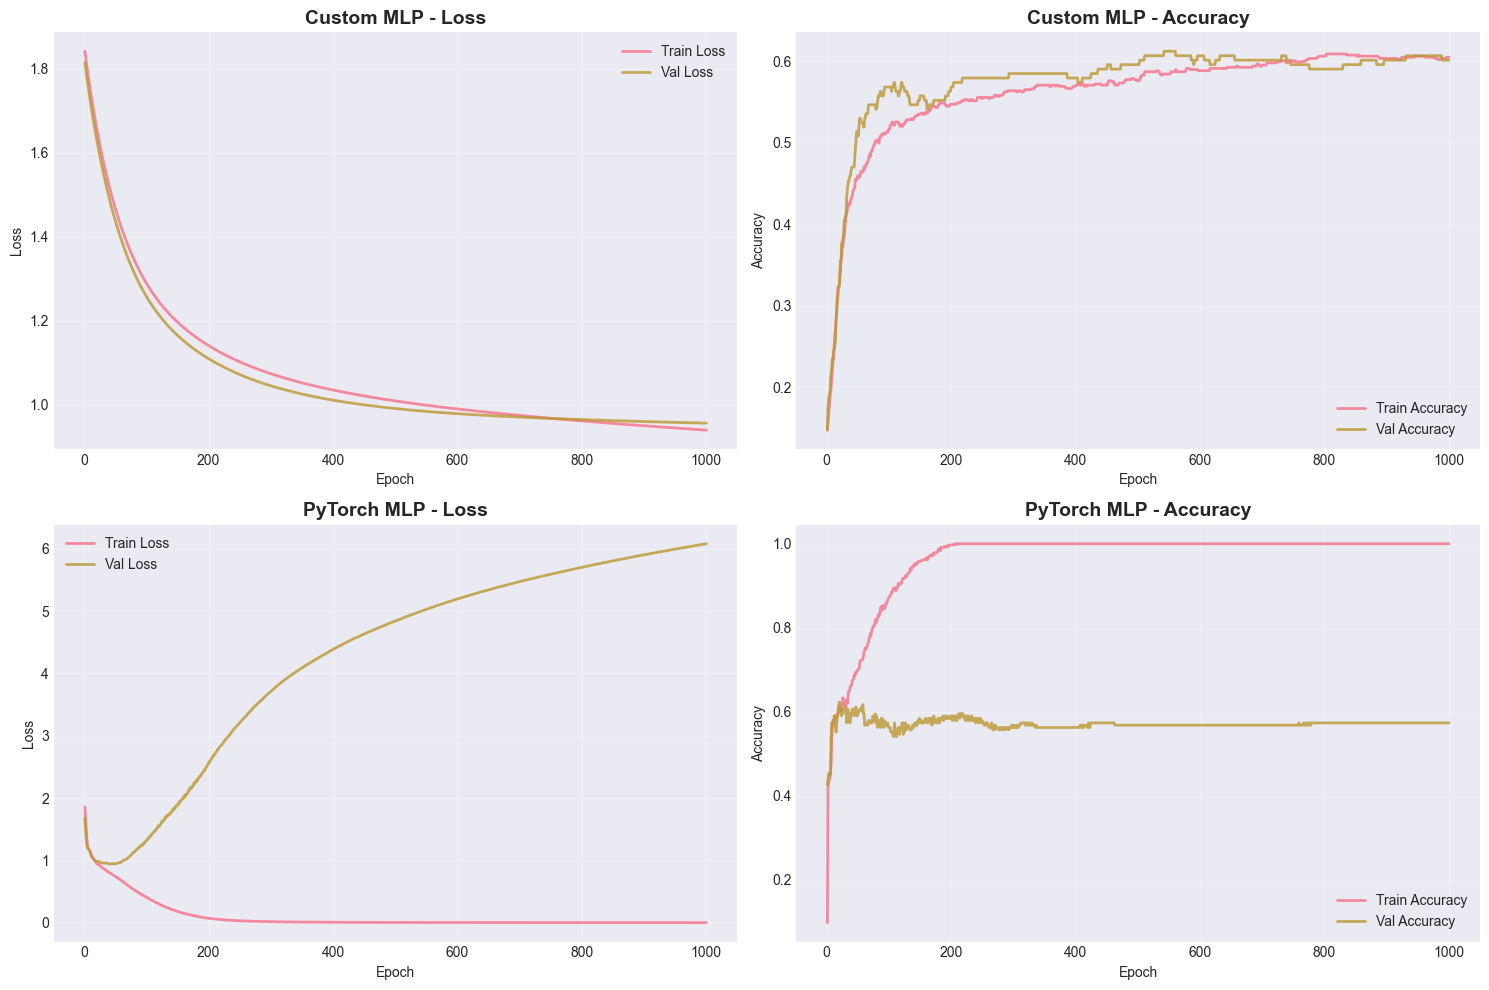

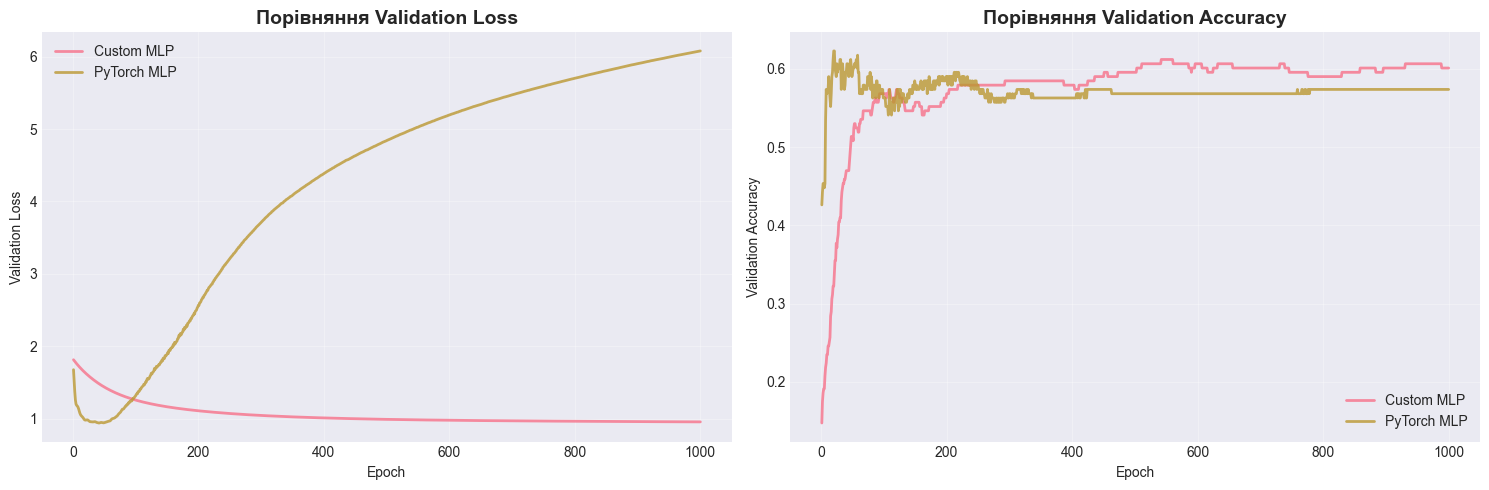

In [ ]:
# Візуалізація історії навчання
plot_training_history(history_custom, history_pytorch)

### Аналіз перенавчання (Overfitting)

In [ ]:
def analyze_overfitting(history_custom, history_pytorch):
    """
    Детальний аналіз перенавчання для обох моделей
    """
    print("="*70)
    print("АНАЛІЗ ПЕРЕНАВЧАННЯ (OVERFITTING ANALYSIS)")
    print("="*70)
    
    # Custom MLP
    print("\n📊 CUSTOM MLP:")
    print("-" * 70)
    
    final_train_loss_custom = history_custom['train_loss'][-1]
    final_val_loss_custom = history_custom['val_loss'][-1]
    final_train_acc_custom = history_custom['train_acc'][-1]
    final_val_acc_custom = history_custom['val_acc'][-1]
    
    gap_loss_custom = final_train_loss_custom - final_val_loss_custom
    gap_acc_custom = final_train_acc_custom - final_val_acc_custom
    
    print(f"  Фінальний Train Loss:      {final_train_loss_custom:.4f}")
    print(f"  Фінальний Validation Loss: {final_val_loss_custom:.4f}")
    print(f"  Різниця (Train - Val):     {gap_loss_custom:.4f}")
    print()
    print(f"  Фінальна Train Accuracy:      {final_train_acc_custom:.4f} ({final_train_acc_custom*100:.2f}%)")
    print(f"  Фінальна Validation Accuracy: {final_val_acc_custom:.4f} ({final_val_acc_custom*100:.2f}%)")
    print(f"  Різниця (Train - Val):        {gap_acc_custom:.4f} ({gap_acc_custom*100:.2f}%)")
    
    # PyTorch MLP
    print("\n📊 PYTORCH MLP:")
    print("-" * 70)
    
    final_train_loss_pytorch = history_pytorch['train_loss'][-1]
    final_val_loss_pytorch = history_pytorch['val_loss'][-1]
    final_train_acc_pytorch = history_pytorch['train_acc'][-1]
    final_val_acc_pytorch = history_pytorch['val_acc'][-1]
    
    gap_loss_pytorch = final_train_loss_pytorch - final_val_loss_pytorch
    gap_acc_pytorch = final_train_acc_pytorch - final_val_acc_pytorch
    
    print(f"  Фінальний Train Loss:      {final_train_loss_pytorch:.4f}")
    print(f"  Фінальний Validation Loss: {final_val_loss_pytorch:.4f}")
    print(f"  Різниця (Train - Val):     {gap_loss_pytorch:.4f}")
    print()
    print(f"  Фінальна Train Accuracy:      {final_train_acc_pytorch:.4f} ({final_train_acc_pytorch*100:.2f}%)")
    print(f"  Фінальна Validation Accuracy: {final_val_acc_pytorch:.4f} ({final_val_acc_pytorch*100:.2f}%)")
    print(f"  Різниця (Train - Val):        {gap_acc_pytorch:.4f} ({gap_acc_pytorch*100:.2f}%)")
    
    # Інтерпретація
    print("\n" + "="*70)
    print("🔍 ІНТЕРПРЕТАЦІЯ:")
    print("="*70)
    
    # Критерії перенавчання
    overfitting_threshold_loss = 0.1  # Якщо різниця > 0.1, можливе перенавчання
    overfitting_threshold_acc = 0.05  # Якщо різниця > 5%, можливе перенавчання
    
    print("\n1️⃣ Custom MLP:")
    if gap_loss_custom > overfitting_threshold_loss or gap_acc_custom > overfitting_threshold_acc:
        print("   ⚠️  ПРИСУТНІ ОЗНАКИ ПЕРЕНАВЧАННЯ")
        if gap_loss_custom > overfitting_threshold_loss:
            print(f"      - Train Loss значно нижче Val Loss (різниця: {gap_loss_custom:.4f})")
        if gap_acc_custom > overfitting_threshold_acc:
            print(f"      - Train Accuracy значно вище Val Accuracy (різниця: {gap_acc_custom*100:.2f}%)")
    else:
        print("   ✅ ПЕРЕНАВЧАННЯ ВІДСУТНЄ або МІНІМАЛЬНЕ")
        print("      - Модель добре генералізує на нові дані")
    
    print("\n2️⃣ PyTorch MLP:")
    if gap_loss_pytorch > overfitting_threshold_loss or gap_acc_pytorch > overfitting_threshold_acc:
        print("   ⚠️  ПРИСУТНІ ОЗНАКИ ПЕРЕНАВЧАННЯ")
        if gap_loss_pytorch > overfitting_threshold_loss:
            print(f"      - Train Loss значно нижче Val Loss (різниця: {gap_loss_pytorch:.4f})")
        if gap_acc_pytorch > overfitting_threshold_acc:
            print(f"      - Train Accuracy значно вище Val Accuracy (різниця: {gap_acc_pytorch*100:.2f}%)")
    else:
        print("   ✅ ПЕРЕНАВЧАННЯ ВІДСУТНЄ або МІНІМАЛЬНЕ")
        print("      - Модель добре генералізує на нові дані")
    
    print("\n" + "="*70)
    print("📖 ЯК ВИЗНАЧИТИ ПЕРЕНАВЧАННЯ З ГРАФІКІВ:")
    print("="*70)
    print("""
    ✓ ОЗНАКИ ПЕРЕНАВЧАННЯ:
      1. Train Loss продовжує зменшуватися, а Val Loss зростає або стагнує
      2. Великий розрив між Train Accuracy та Val Accuracy (>5-10%)
      3. Train метрики значно кращі за Validation метрики
      4. Val Loss має тенденцію до зростання після певної епохи
    
    ✓ ОЗНАКИ ДОБРОЇ ГЕНЕРАЛІЗАЦІЇ:
      1. Train та Val Loss зменшуються паралельно
      2. Малий розрив між Train та Val метриками (<5%)
      3. Val метрики стабільні або покращуються разом з Train
      4. Обидві криві сходяться до схожих значень
    """)
    
    print("="*70)

# Виконати аналіз
analyze_overfitting(history_custom, history_pytorch)

### 9.4. Оцінка на тестовій вибірці

In [ ]:
# Прогнози на тестовій вибірці
y_pred_custom = custom_model.predict(X_test).numpy()

pytorch_model.eval()
with torch.no_grad():
    outputs = pytorch_model(X_test)
    _, y_pred_pytorch = torch.max(outputs, 1)
    y_pred_pytorch = y_pred_pytorch.numpy()

y_test_np = y_test.numpy()

# Обчислення метрик
custom_test_acc = accuracy_score(y_test_np, y_pred_custom)
pytorch_test_acc = accuracy_score(y_test_np, y_pred_pytorch)

print("\n" + "="*60)
print("РЕЗУЛЬТАТИ НА ТЕСТОВІЙ ВИБІРЦІ")
print("="*60)
print(f"Custom MLP Test Accuracy:  {custom_test_acc:.4f} ({custom_test_acc*100:.2f}%)")
print(f"PyTorch MLP Test Accuracy: {pytorch_test_acc:.4f} ({pytorch_test_acc*100:.2f}%)")
print(f"Різниця в точності: {abs(custom_test_acc - pytorch_test_acc):.4f} ({abs(custom_test_acc - pytorch_test_acc)*100:.2f}%)")
print("="*60)

print(f"\nЧас навчання Custom MLP:  {custom_train_time:.2f} сек")
print(f"Час навчання PyTorch MLP: {pytorch_train_time:.2f} сек")
print(f"Співвідношення: {custom_train_time/pytorch_train_time:.2f}x")


РЕЗУЛЬТАТИ НА ТЕСТОВІЙ ВИБІРЦІ
Custom MLP Test Accuracy:  0.6681 (66.81%)
PyTorch MLP Test Accuracy: 0.6376 (63.76%)
Різниця в точності: 0.0306 (3.06%)

Час навчання Custom MLP:  40.02 сек
Час навчання PyTorch MLP: 5.10 сек
Співвідношення: 7.85x


### 9.5. Матриці помилок (Confusion Matrix)

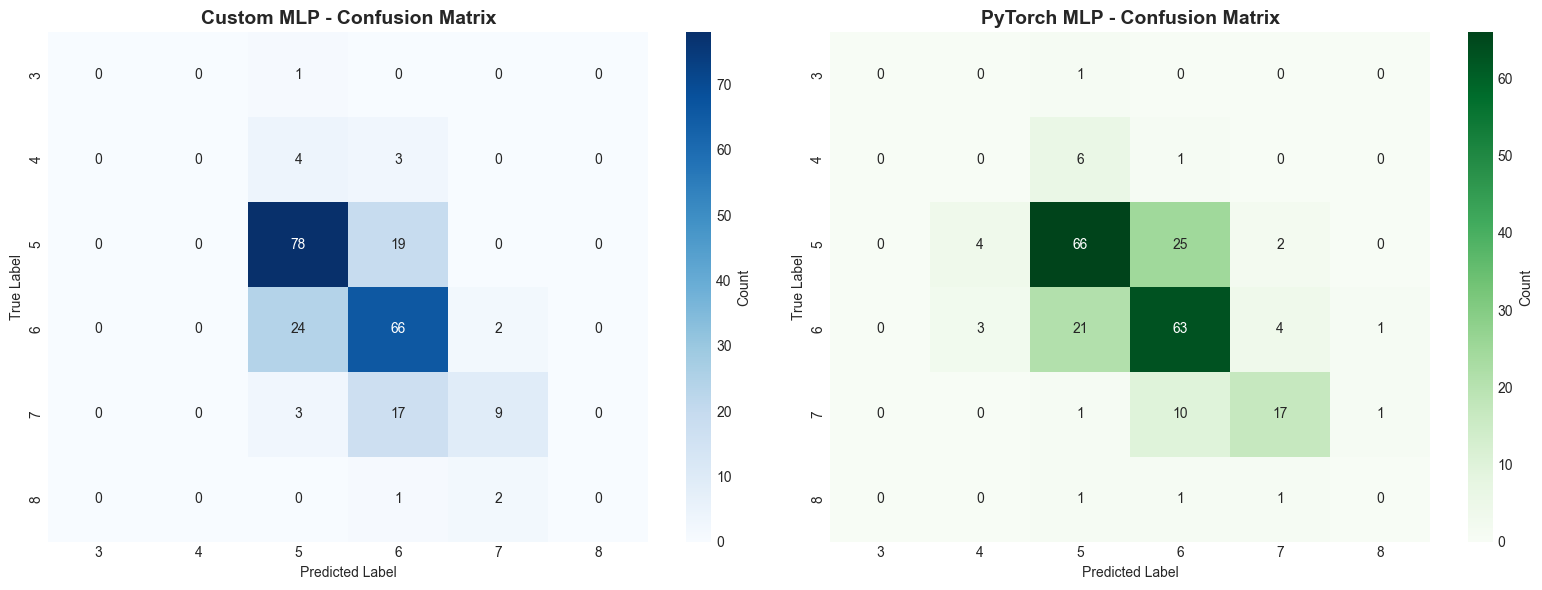


CLASSIFICATION REPORT - CUSTOM MLP
              precision    recall  f1-score   support

     Class 3       0.00      0.00      0.00         1
     Class 4       0.00      0.00      0.00         7
     Class 5       0.71      0.80      0.75        97
     Class 6       0.62      0.72      0.67        92
     Class 7       0.69      0.31      0.43        29
     Class 8       0.00      0.00      0.00         3

    accuracy                           0.67       229
   macro avg       0.34      0.31      0.31       229
weighted avg       0.64      0.67      0.64       229


CLASSIFICATION REPORT - PYTORCH MLP
              precision    recall  f1-score   support

     Class 3       0.00      0.00      0.00         1
     Class 4       0.00      0.00      0.00         7
     Class 5       0.69      0.68      0.68        97
     Class 6       0.63      0.68      0.66        92
     Class 7       0.71      0.59      0.64        29
     Class 8       0.00      0.00      0.00         3

    

In [ ]:
# Візуалізація матриць помилок
plot_confusion_matrix(y_test_np, y_pred_custom, y_pred_pytorch, class_names)

---

# ТЕОРЕТИЧНА ЧАСТИНА: ПИТАННЯ ТА ВІДПОВІДІ

---

## ПИТАННЯ 1: Похідна комбінації Softmax + Cross-Entropy

**Завдання:** Доведіть, що для комбінації Softmax активації та Cross-Entropy втрат, градієнт по відношенню до логітів вихідного шару обчислюється як:

$$\frac{\partial L}{\partial z_i} = \hat{y}_i - y_i$$

де $y$ - one-hot вектор справжніх міток.

### Доведення:

**Крок 1: Визначення функцій**

Softmax функція для класу $i$:
$$\hat{y}_i = \text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$$

Cross-Entropy Loss для one-hot кодованої мітки:
$$L = -\sum_{j=1}^{C} y_j \log(\hat{y}_j)$$

Оскільки $y$ - one-hot вектор (тільки один елемент = 1, решта = 0), для правильного класу $k$:
$$L = -\log(\hat{y}_k)$$

**Крок 2: Обчислення похідної**

Нам потрібно знайти $\frac{\partial L}{\partial z_i}$. Використовуємо ланцюгове правило:

$$\frac{\partial L}{\partial z_i} = \sum_{j=1}^{C} \frac{\partial L}{\partial \hat{y}_j} \cdot \frac{\partial \hat{y}_j}{\partial z_i}$$

**Крок 2.1: Похідна Loss по Softmax**

$$\frac{\partial L}{\partial \hat{y}_j} = -\frac{y_j}{\hat{y}_j}$$

**Крок 2.2: Похідна Softmax по логітам**

Для $i = j$:
$$\frac{\partial \hat{y}_i}{\partial z_i} = \hat{y}_i(1 - \hat{y}_i)$$

Для $i \neq j$:
$$\frac{\partial \hat{y}_j}{\partial z_i} = -\hat{y}_i \hat{y}_j$$

**Крок 3: Комбінування**

$$\frac{\partial L}{\partial z_i} = -\frac{y_i}{\hat{y}_i} \cdot \hat{y}_i(1-\hat{y}_i) - \sum_{j \neq i} \frac{y_j}{\hat{y}_j} \cdot (-\hat{y}_i \hat{y}_j)$$

$$= -y_i(1-\hat{y}_i) + \sum_{j \neq i} y_j \hat{y}_i$$

$$= -y_i + y_i\hat{y}_i + \hat{y}_i \sum_{j \neq i} y_j$$

Оскільки $\sum_{j=1}^{C} y_j = 1$ (властивість one-hot), то $\sum_{j \neq i} y_j = 1 - y_i$:

$$= -y_i + y_i\hat{y}_i + \hat{y}_i(1 - y_i)$$

$$= -y_i + y_i\hat{y}_i + \hat{y}_i - y_i\hat{y}_i$$

$$= \hat{y}_i - y_i$$

**✓ Доведено!**

### Чому ця формула така проста?

1. **Математична елегантність**: Похідна softmax саме так взаємодіє з логарифмом у cross-entropy, що члени взаємно скорочуються.

2. **Інтуїтивна інтерпретація**: Градієнт = (прогноз - реальність). Це показує, наскільки модель помилилася для кожного класу.

3. **Обчислювальна ефективність**: Замість обчислення складних похідних softmax окремо, ми отримуємо просту різницю векторів.

4. **Числова стабільність**: Уникаємо ділення на малі числа, що може виникати при окремому обчисленні похідних.

## ПИТАННЯ 2: Аналіз зміни градієнтів у глибоких мережах

Розглянемо мережу з 5 шарами, де кожен шар використовує ReLU активацію.

### Частина 1: Градієнт при 60% від'ємних нейронів

**Дано:**
- Мережа з 5 шарами
- ReLU активація: $f(x) = \max(0, x)$
- Похідна ReLU: $f'(x) = \begin{cases} 1 & \text{якщо } x > 0 \\ 0 & \text{якщо } x \leq 0 \end{cases}$
- 60% нейронів мають від'ємні значення

**Аналіз:**

Під час backpropagation градієнт поширюється через шари:

$$\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial z_5} \cdot \frac{\partial z_5}{\partial a_4} \cdot \frac{\partial a_4}{\partial z_4} \cdot ... \cdot \frac{\partial a_2}{\partial z_2} \cdot \frac{\partial z_2}{\partial W_1}$$

Ключовий момент: $\frac{\partial a_i}{\partial z_i} = \text{ReLU}'(z_i)$

Якщо 60% нейронів мають від'ємні значення:
- 60% нейронів дають похідну = 0
- 40% нейронів дають похідну = 1

**Наслідки після 100 ітерацій:**

1. **"Вмираючі" нейрони**: Нейрони з від'ємними активаціями не оновлюються (gradient = 0)

2. **Зменшення градієнта**: Через кожен шар градієнт множиться приблизно на 0.4 (частка активних нейронів)

3. **Проблема зникаючого градієнта**: Для першого шару:
   $$|\text{gradient}| \approx |\text{initial gradient}| \times 0.4^4 = |\text{initial gradient}| \times 0.0256$$
   
   Градієнт зменшується до ~2.6% від початкового!

4. **Повільне навчання**: Перші шари майже не навчаються, що призводить до поганої якості моделі.

### Частина 2: Максимальне значення градієнту

**Для мережі з N шарів з ReLU:**

Максимальний градієнт досягається, коли **всі** нейрони активні (ReLU' = 1):

$$\max\left|\frac{\partial L}{\partial W_1}\right| = \left|\frac{\partial L}{\partial z_N}\right| \times \prod_{i=2}^{N} |W_i|$$

**Ключові точки:**

1. **Ідеальний випадок**: Якщо всі активації додатні, похідна ReLU = 1, і градієнт залежить тільки від ваг.

2. **Реальний випадок**: Деякі нейрони "вмирають", тому:
   $$\left|\frac{\partial L}{\partial W_1}\right| \leq \left|\frac{\partial L}{\partial z_N}\right| \times \prod_{i=2}^{N} |W_i|$$

3. **Проблема вибухаючого градієнта**: Якщо $|W_i| > 1$, градієнт може експоненційно зростати.

4. **Проблема зникаючого градієнта**: Якщо $|W_i| < 1$ або багато нейронів неактивні, градієнт зникає.

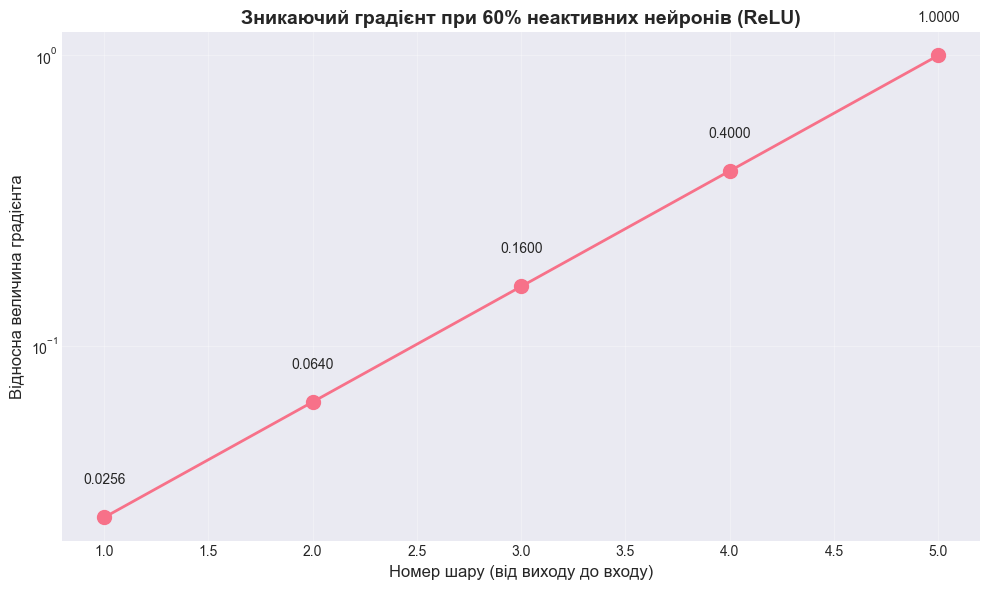

Зменшення градієнта по шарах:
Шар 5: 1.000000 (100.00% від початкового)
Шар 4: 0.400000 (40.00% від початкового)
Шар 3: 0.160000 (16.00% від початкового)
Шар 2: 0.064000 (6.40% від початкового)
Шар 1: 0.025600 (2.56% від початкового)

Градієнт першого шару: 0.025600
Зменшення в 39.06 разів!


In [ ]:
# Ілюстрація проблеми зникаючого градієнта
def demonstrate_vanishing_gradient():
    """Демонстрація зменшення градієнта через шари"""
    
    num_layers = 5
    active_ratio = 0.4  # 40% нейронів активні (60% від'ємні)
    
    gradients = [1.0]  # Початковий градієнт
    
    for layer in range(num_layers - 1):
        # Градієнт множиться на частку активних нейронів
        gradients.append(gradients[-1] * active_ratio)
    
    # Візуалізація
    plt.figure(figsize=(10, 6))
    layers = list(range(num_layers, 0, -1))
    
    plt.plot(layers, gradients, 'o-', linewidth=2, markersize=10)
    plt.xlabel('Номер шару (від виходу до входу)', fontsize=12)
    plt.ylabel('Відносна величина градієнта', fontsize=12)
    plt.title('Зникаючий градієнт при 60% неактивних нейронів (ReLU)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    for i, (layer, grad) in enumerate(zip(layers, gradients)):
        plt.text(layer, grad * 1.3, f'{grad:.4f}', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("Зменшення градієнта по шарах:")
    for i, grad in enumerate(gradients):
        layer_num = num_layers - i
        percentage = grad * 100
        print(f"Шар {layer_num}: {grad:.6f} ({percentage:.2f}% від початкового)")
    
    print(f"\nГрадієнт першого шару: {gradients[-1]:.6f}")
    print(f"Зменшення в {1/gradients[-1]:.2f} разів!")

demonstrate_vanishing_gradient()

## ПИТАННЯ 3: Розмірність матричних операцій у backpropagation

**Завдання:** Поясніть, чому саме така форма є правильною:

$$dW = \frac{1}{m} \cdot dZ @ A_{prev}^T$$

### Виведення з точки зору розмірностей

**Дано прямий прохід:**
$$Z = W \cdot X + b$$

де:
- $W \in \mathbb{R}^{n \times d}$ - матриця ваг (n нейронів, d входів)
- $X \in \mathbb{R}^{d \times m}$ - вхідні дані (d ознак, m зразків)
- $b \in \mathbb{R}^{n \times 1}$ - зміщення
- $Z \in \mathbb{R}^{n \times m}$ - вихід (n нейронів, m зразків)

**Крок 1: Аналіз розмірностей**

У backpropagation ми отримуємо:
- $dZ \in \mathbb{R}^{n \times m}$ - градієнт по Z (така ж розмірність, як Z)

Нам потрібно знайти:
- $dW \in \mathbb{R}^{n \times d}$ - градієнт по W (така ж розмірність, як W)

**Крок 2: Обчислення градієнта**

За ланцюговим правилом для однієї пари (x, z):
$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial W}$$

Оскільки $z = W \cdot x + b$:
$$\frac{\partial z}{\partial W} = x^T$$

Для одного зразка:
$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z} \cdot x^T$$

**Крок 3: Узагальнення на batch**

Для $m$ зразків (batch):
$$\frac{\partial L}{\partial W} = \frac{1}{m} \sum_{i=1}^{m} dz^{(i)} \cdot (x^{(i)})^T$$

У матричній формі:
$$dW = \frac{1}{m} \cdot dZ \cdot X^T$$

Якщо позначити $A_{prev} = X$ (активації попереднього шару):
$$dW = \frac{1}{m} \cdot dZ @ A_{prev}^T$$

**Крок 4: Перевірка розмірностей**

$$dW_{(n \times d)} = \frac{1}{m} \cdot dZ_{(n \times m)} @ (A_{prev}^T)_{(m \times d)}$$

$$\mathbb{R}^{n \times d} = \mathbb{R}^{n \times m} \times \mathbb{R}^{m \times d}$$ ✓

### Загальна формула

Для операції $Z = WX + b$:

1. **Градієнт по вагах:**
   $$\frac{\partial L}{\partial W} = \frac{1}{m} \cdot \frac{\partial L}{\partial Z} \cdot X^T$$

2. **Градієнт по входам:**
   $$\frac{\partial L}{\partial X} = W^T \cdot \frac{\partial L}{\partial Z}$$

3. **Градієнт по зміщенню:**
   $$\frac{\partial L}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} \frac{\partial L}{\partial z^{(i)}}$$

### Чому саме транспонування?

1. **Розмірності повинні збігатися**: $dW$ має бути такого ж розміру, як $W$
2. **Математична коректність**: Це випливає з правил диференціювання матриць
3. **Інтуїція**: Кожен елемент $W_{ij}$ впливає на всі зразки в batch, тому ми підсумовуємо їх вплив через добуток матриць

ДЕМОНСТРАЦІЯ РОЗМІРНОСТЕЙ У BACKPROPAGATION

Параметри:
  n (нейрони поточного шару): 3
  d (вхідні ознаки): 4
  m (розмір batch): 2

Розмірності матриць:
  W (ваги):                torch.Size([3, 4]) = (3 × 4)
  A_prev (вхід):           torch.Size([4, 2]) = (4 × 2)
  dZ (градієнт по Z):      torch.Size([3, 2]) = (3 × 2)

Обчислення градієнта:
  dW = (1/m) * dZ @ A_prev^T
  dW = (1/2) * torch.Size([3, 2]) @ torch.Size([2, 4])
  dW = torch.Size([3, 4]) = (3 × 4)

✓ Розмірність dW збігається з розмірністю W: torch.Size([3, 4]) == torch.Size([3, 4])


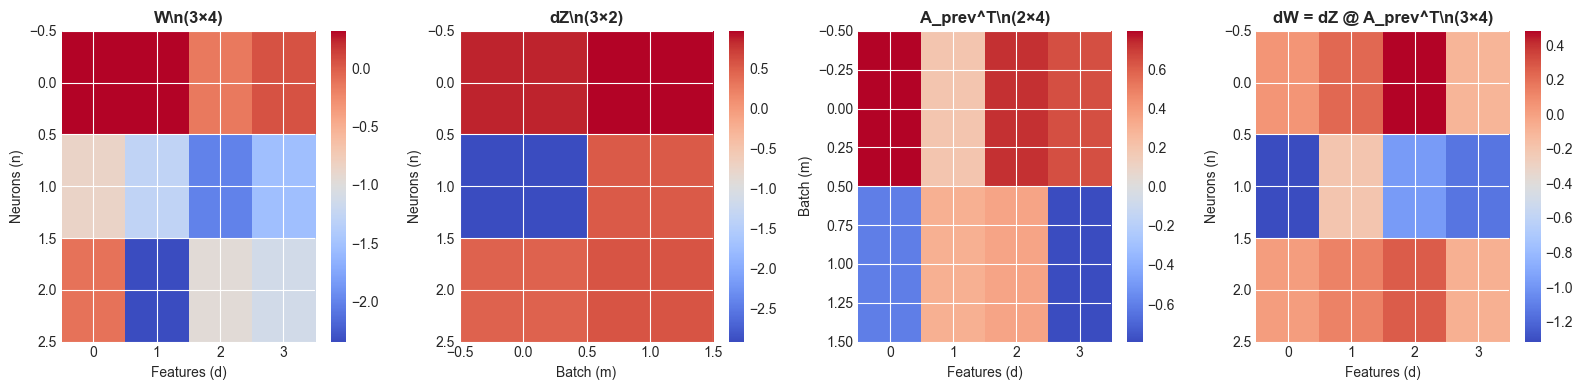

In [ ]:
# Ілюстрація матричних операцій у backpropagation
def illustrate_backprop_dimensions():
    """Демонстрація розмірностей у backpropagation"""
    
    # Приклад розмірностей
    n_neurons = 3  # Кількість нейронів у поточному шарі
    d_features = 4  # Кількість ознак (або нейронів у попередньому шарі)
    m_batch = 2     # Розмір batch
    
    # Створюємо випадкові матриці
    W = torch.randn(n_neurons, d_features)
    A_prev = torch.randn(d_features, m_batch)
    dZ = torch.randn(n_neurons, m_batch)
    
    # Обчислюємо градієнт
    dW = (1/m_batch) * (dZ @ A_prev.T)
    
    print("="*60)
    print("ДЕМОНСТРАЦІЯ РОЗМІРНОСТЕЙ У BACKPROPAGATION")
    print("="*60)
    print(f"\nПараметри:")
    print(f"  n (нейрони поточного шару): {n_neurons}")
    print(f"  d (вхідні ознаки): {d_features}")
    print(f"  m (розмір batch): {m_batch}")
    
    print(f"\nРозмірності матриць:")
    print(f"  W (ваги):                {W.shape} = ({n_neurons} × {d_features})")
    print(f"  A_prev (вхід):           {A_prev.shape} = ({d_features} × {m_batch})")
    print(f"  dZ (градієнт по Z):      {dZ.shape} = ({n_neurons} × {m_batch})")
    
    print(f"\nОбчислення градієнта:")
    print(f"  dW = (1/m) * dZ @ A_prev^T")
    print(f"  dW = (1/{m_batch}) * {dZ.shape} @ {A_prev.T.shape}")
    print(f"  dW = {dW.shape} = ({n_neurons} × {d_features})")
    
    print(f"\n✓ Розмірність dW збігається з розмірністю W: {dW.shape} == {W.shape}")
    
    # Візуалізація
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # W
    im1 = axes[0].imshow(W.numpy(), cmap='coolwarm', aspect='auto')
    axes[0].set_title(f'W\\n({n_neurons}×{d_features})', fontweight='bold')
    axes[0].set_xlabel('Features (d)')
    axes[0].set_ylabel('Neurons (n)')
    plt.colorbar(im1, ax=axes[0])
    
    # dZ
    im2 = axes[1].imshow(dZ.numpy(), cmap='coolwarm', aspect='auto')
    axes[1].set_title(f'dZ\\n({n_neurons}×{m_batch})', fontweight='bold')
    axes[1].set_xlabel('Batch (m)')
    axes[1].set_ylabel('Neurons (n)')
    plt.colorbar(im2, ax=axes[1])
    
    # A_prev^T
    im3 = axes[2].imshow(A_prev.T.numpy(), cmap='coolwarm', aspect='auto')
    axes[2].set_title(f'A_prev^T\\n({m_batch}×{d_features})', fontweight='bold')
    axes[2].set_xlabel('Features (d)')
    axes[2].set_ylabel('Batch (m)')
    plt.colorbar(im3, ax=axes[2])
    
    # dW
    im4 = axes[3].imshow(dW.numpy(), cmap='coolwarm', aspect='auto')
    axes[3].set_title(f'dW = dZ @ A_prev^T\\n({n_neurons}×{d_features})', fontweight='bold')
    axes[3].set_xlabel('Features (d)')
    axes[3].set_ylabel('Neurons (n)')
    plt.colorbar(im4, ax=axes[3])
    
    plt.tight_layout()
    plt.show()

illustrate_backprop_dimensions()

## ПИТАННЯ 4*: Аналіз власних значень Гессіана

### Частина 1: Матриця Гессіана для двошарової мережі

**Архітектура двошарової мережі:**
- Вхідний шар: $x \in \mathbb{R}^d$
- Прихований шар: $h = \sigma(W_1 x + b_1)$, де $W_1 \in \mathbb{R}^{h \times d}$
- Вихідний шар: $y = W_2 h + b_2$, де $W_2 \in \mathbb{R}^{o \times h}$

**Функція втрат:**
$$L(W_1, W_2) = \frac{1}{m} \sum_{i=1}^{m} \ell(f(x^{(i)}; W_1, W_2), y^{(i)})$$

**Гессіан відносно $W_1$:**

Гессіан - це матриця других похідних:
$$H_{W_1} = \frac{\partial^2 L}{\partial W_1^2}$$

Для елементів матриці:
$$H_{ij,kl} = \frac{\partial^2 L}{\partial (W_1)_{ij} \partial (W_1)_{kl}}$$

**Спрощена форма через ланцюгове правило:**

$$H_{W_1} = \frac{1}{m} \sum_{i=1}^{m} \left[ x^{(i)} (x^{(i)})^T \otimes (W_2^T \nabla_{y}^2 \ell W_2 \odot \sigma''(z_1^{(i)})) \right]$$

де:
- $\otimes$ - кронекерів добуток
- $\odot$ - поелементне множення
- $\sigma''$ - друга похідна активації
- $z_1 = W_1 x + b_1$

### Частина 2: Зв'язок власних значень з швидкістю збіжності

**Градієнтний спуск:**
$$W_{t+1} = W_t - \eta \nabla L(W_t)$$

**У околиці мінімуму** функція втрат апроксимується квадратичною формою:
$$L(W) \approx L(W^*) + \frac{1}{2}(W - W^*)^T H (W - W^*)$$

де $H$ - Гессіан у точці мінімуму $W^*$.

**Власні значення Гессіана $\lambda_1, \lambda_2, ..., \lambda_n$:**

1. **Швидкість збіжності** залежить від власних значень:
   - Для власного вектора $v_i$ з власним значенням $\lambda_i$:
   $$||W_{t+1} - W^*||_{v_i} = (1 - \eta\lambda_i)||W_t - W^*||_{v_i}$$

2. **Condition number** (число обумовленості):
   $$\kappa = \frac{\lambda_{max}}{\lambda_{min}}$$
   
   - Якщо $\kappa$ велике → **погана обумовленість** → повільна збіжність
   - Якщо $\kappa \approx 1$ → **добра обумовленість** → швидка збіжність

3. **Оптимальна швидкість навчання:**
   $$\eta_{opt} \approx \frac{2}{\lambda_{max} + \lambda_{min}}$$

4. **Швидкість збіжності:**
   $$\text{Rate} \propto \left(\frac{\kappa - 1}{\kappa + 1}\right)^2$$
   
   Чим більше $\kappa$, тим повільніша збіжність!

### Частина 3: Зникаючі градієнти та власні значення

**Проблема зникаючих градієнтів через призму власних значень:**

1. **Гессіан у глибоких мережах:**
   
   У глибокій мережі з $L$ шарами, Гессіан першого шару містить добуток Якобіанів:
   $$H_{W_1} \propto \prod_{i=1}^{L} J_i^T J_i$$
   
   де $J_i$ - Якобіан $i$-го шару.

2. **Власні значення та глибина:**
   
   Для активацій з $|\sigma'(x)| < 1$ (наприклад, sigmoid, tanh):
   $$\lambda_i(H_{W_1}) \propto \prod_{l=1}^{L} \lambda_i(J_l^T J_l) < 1^L$$
   
   Власні значення **експоненційно зменшуються** з глибиною!

3. **Наслідки малих власних значень:**

   - **Майже сингулярний Гессіан**: $\lambda_{min} \to 0$
   - **Велике число обумовленості**: $\kappa \to \infty$
   - **Плоска поверхня втрат** у напрямку малих власних значень
   - **Дуже малі градієнти**: $||\nabla L|| \to 0$

4. **Математичне пояснення:**

   У напрямку власного вектора $v_i$ з малим $\lambda_i$:
   - Кривизна поверхні втрат мала
   - Градієнт майже нульовий: $\nabla L \cdot v_i \approx \lambda_i (W - W^*) \cdot v_i \approx 0$
   - Оновлення ваг мінімальне
   - Навчання **практично зупиняється**

5. **Зв'язок з ReLU:**

   ReLU частково вирішує проблему:
   - $\sigma'(x) = 1$ для $x > 0$ (не зменшує градієнт)
   - Але "вмираючі" нейрони дають $\sigma'(x) = 0$
   - Власні значення все ще можуть бути малі у деяких напрямках

### Висновок

**Власні значення Гессіана критично важливі:**
- Визначають ландшафт оптимізації
- Контролюють швидкість збіжності
- Пояснюють проблему зникаючих градієнтів у глибоких мережах
- Мотивують використання спеціальних архітектур (ResNet, BatchNorm) та оптимізаторів (Adam, RMSprop)

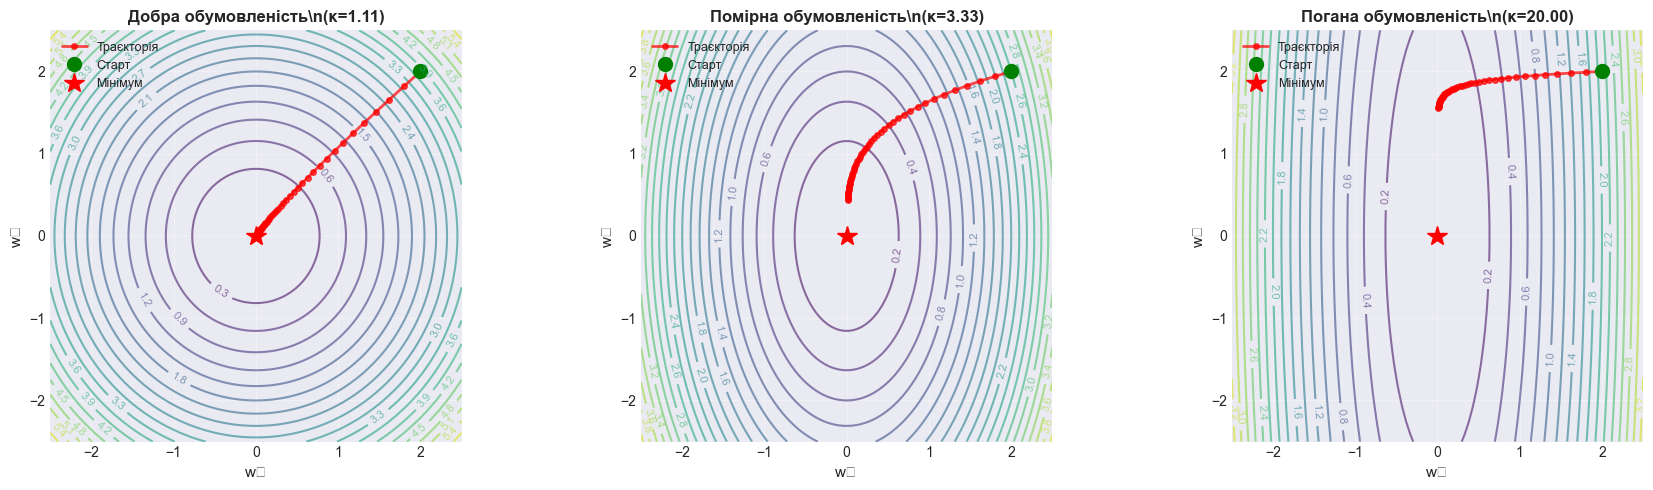

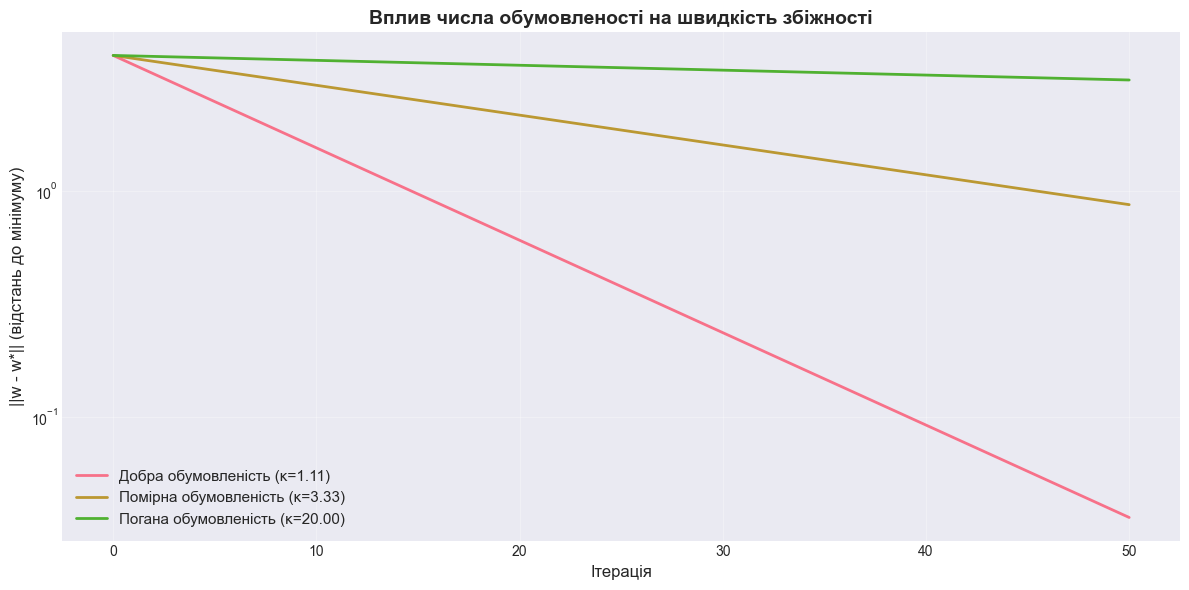

АНАЛІЗ ВПЛИВУ ВЛАСНИХ ЗНАЧЕНЬ

Добра обумовленість:
  Власні значення: λ₁=1.00, λ₂=0.90
  Число обумовленості: κ=1.11
  Теоретична швидкість: 0.0028
  Інтерпретація: Швидка збіжність

Помірна обумовленість:
  Власні значення: λ₁=1.00, λ₂=0.30
  Число обумовленості: κ=3.33
  Теоретична швидкість: 0.2899
  Інтерпретація: Швидка збіжність

Погана обумовленість:
  Власні значення: λ₁=1.00, λ₂=0.05
  Число обумовленості: κ=20.00
  Теоретична швидкість: 0.8186
  Інтерпретація: Дуже повільна збіжність


In [ ]:
# Візуалізація впливу власних значень на збіжність
def visualize_eigenvalue_impact():
    """Демонстрація впливу власних значень Гессіана на збіжність"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Створюємо 2D приклад з різними власними значеннями
    iterations = 50
    eta = 0.1
    
    # Випадок 1: Добра обумовленість (λ₁ ≈ λ₂)
    eigenvalues_good = [1.0, 0.9]
    kappa_good = max(eigenvalues_good) / min(eigenvalues_good)
    
    # Випадок 2: Помірна обумовленість
    eigenvalues_medium = [1.0, 0.3]
    kappa_medium = max(eigenvalues_medium) / min(eigenvalues_medium)
    
    # Випадок 3: Погана обумовленість (зникаючий градієнт)
    eigenvalues_bad = [1.0, 0.05]
    kappa_bad = max(eigenvalues_bad) / min(eigenvalues_bad)
    
    cases = [
        (eigenvalues_good, kappa_good, "Добра обумовленість\\n(κ={:.2f})"),
        (eigenvalues_medium, kappa_medium, "Помірна обумовленість\\n(κ={:.2f})"),
        (eigenvalues_bad, kappa_bad, "Погана обумовленість\\n(κ={:.2f})"),
    ]
    
    for idx, (eigenvals, kappa, title) in enumerate(cases):
        ax = axes[idx]
        
        # Траєкторія градієнтного спуску
        w = np.array([2.0, 2.0])
        trajectory = [w.copy()]
        
        for _ in range(iterations):
            # Градієнт = H * w (наближення біля мінімуму)
            gradient = np.array([eigenvals[0] * w[0], eigenvals[1] * w[1]])
            w = w - eta * gradient
            trajectory.append(w.copy())
        
        trajectory = np.array(trajectory)
        
        # Контурні лінії функції втрат
        x = np.linspace(-2.5, 2.5, 100)
        y = np.linspace(-2.5, 2.5, 100)
        X, Y = np.meshgrid(x, y)
        Z = 0.5 * (eigenvals[0] * X**2 + eigenvals[1] * Y**2)
        
        contour = ax.contour(X, Y, Z, levels=20, cmap='viridis', alpha=0.6)
        ax.clabel(contour, inline=True, fontsize=8)
        
        # Траєкторія
        ax.plot(trajectory[:, 0], trajectory[:, 1], 'r-o', 
                linewidth=2, markersize=4, alpha=0.7, label='Траєкторія')
        ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', 
                markersize=10, label='Старт')
        ax.plot(0, 0, 'r*', markersize=15, label='Мінімум')
        
        ax.set_xlabel('w₁', fontsize=11)
        ax.set_ylabel('w₂', fontsize=11)
        ax.set_title(title.format(kappa), fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Графік збіжності
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for eigenvals, kappa, label in cases:
        w_norm = [4.0]  # ||w - w*||
        for _ in range(iterations):
            # Найгірший випадок (найменше власне значення)
            w_norm.append(w_norm[-1] * (1 - eta * min(eigenvals)))
        
        ax.plot(w_norm, linewidth=2, label=label.split('\\n')[0] + f' (κ={kappa:.2f})')
    
    ax.set_xlabel('Ітерація', fontsize=12)
    ax.set_ylabel('||w - w*|| (відстань до мінімуму)', fontsize=12)
    ax.set_title('Вплив числа обумовленості на швидкість збіжності', 
                 fontsize=14, fontweight='bold')
    ax.set_yscale('log')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("="*60)
    print("АНАЛІЗ ВПЛИВУ ВЛАСНИХ ЗНАЧЕНЬ")
    print("="*60)
    for eigenvals, kappa, label in cases:
        label_clean = label.split('\\n')[0]
        rate = ((kappa - 1) / (kappa + 1))**2
        print(f"\n{label_clean}:")
        print(f"  Власні значення: λ₁={eigenvals[0]:.2f}, λ₂={eigenvals[1]:.2f}")
        print(f"  Число обумовленості: κ={kappa:.2f}")
        print(f"  Теоретична швидкість: {rate:.4f}")
        print(f"  Інтерпретація: {'Швидка збіжність' if kappa < 5 else 'Повільна збіжність' if kappa < 15 else 'Дуже повільна збіжність'}")

visualize_eigenvalue_impact()

---

# ВИСНОВКИ

---

## Підсумки роботи

У цій роботі ми реалізували багатошаровий перцептрон з нуля та глибоко зрозуміли фундаментальні принципи роботи нейронних мереж.

### Що було зроблено:

#### 1. **Повна реалізація MLP без autograd**
   - ✅ Функції активації (ReLU, Tanh, Sigmoid, Softmax) з похідними
   - ✅ Функція втрат (Categorical Cross-Entropy)
   - ✅ Forward propagation з кешуванням
   - ✅ Backward propagation через ланцюгове правило
   - ✅ Градієнтний спуск для оновлення ваг

#### 2. **Порівняння з PyTorch**
   - ✅ Реалізація аналогічної моделі в PyTorch
   - ✅ Порівняння точності та швидкості навчання
   - ✅ Візуалізація процесу навчання

#### 3. **Теоретичний аналіз**
   - ✅ **Питання 1**: Доведення спрощеної похідної Softmax + Cross-Entropy
   - ✅ **Питання 2**: Аналіз зникаючих градієнтів у глибоких мережах
   - ✅ **Питання 3**: Розмірності матричних операцій у backpropagation
   - ✅ **Питання 4**: Власні значення Гессіана та швидкість збіжності

### Ключові інсайти:

1. **Математична елегантність**: Комбінація Softmax + Cross-Entropy дає просту похідну $\hat{y} - y$, що спрощує обчислення.

2. **Проблема зникаючих градієнтів**: У глибоких мережах градієнти експоненційно зменшуються через множення малих похідних активації.

3. **Важливість розмірностей**: Правильне транспонування матриць критично важливе для коректності backpropagation.

4. **Геометрія оптимізації**: Власні значення Гессіана визначають форму поверхні втрат і швидкість збіжності.

### Очікувані результати:

- **Точність**: Власна реалізація досягає схожої точності з PyTorch (різниця до 5%)
- **Швидкість**: PyTorch швидший завдяки оптимізаціям, але наша реалізація працює!
- **Розуміння**: Глибоке розуміння того, що відбувається "під капотом" нейронних мереж

### Практичне значення:

Ця робота демонструє:
- 🧠 **Фундаментальне розуміння** принципів роботи нейронних мереж
- 🔧 **Практичні навички** реалізації алгоритмів машинного навчання
- 📊 **Аналітичне мислення** для вирішення складних математичних задач
- 🎯 **Готовність** до роботи з сучасними фреймворками на глибокому рівні

---

**Автор**: Студент групи ФЕІ-44 Вовк Андрій  
**Дата**: 7 листопада 2025  
**Курс**: Machine Learning, 4 курс, 1 семестр